## Comparing Mirror and Lazy Mirror descent

In [1]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

## Import Libraries

In [62]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
warnings.filterwarnings('ignore')
from cvxopt import matrix, solvers

In [60]:
class HiddenPrints:       #To suppress print statements during execution of library function
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Class MDP


In [40]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        self.rewards2              = np.zeros((s,a))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards2 = np.random.rand(self.num_state,self.num_action)
        for a in self.actions:
            for s in self.states:
                for s1 in self.states:
                    self.rewards[a][s][s1] = self.rewards2[s][a]

## Utility functions


In [41]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

In [42]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

In [43]:
def P_matrix(env,pi):
    
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
        

In [44]:
def C_pi(env,pi):
    C = np.sum(np.multiply(env.rewards2,pi),axis=1)
    return C

In [45]:
def projection(env,x):
    P = 2*matrix(np.identity(env.num_action))
    q = -2*matrix(x)
    G = -1*matrix(np.identity(env.num_action))
    h = matrix(np.zeros(env.num_action))
    A = matrix(np.ones(env.num_action), (1,env.num_action))
    b = matrix(1.0)
    with HiddenPrints():
        sol=solvers.qp(P, q, G, h, A, b)
    proj= np.reshape(np.array(sol['x']),(1,-1))
    return proj


## Lazy MD

In [78]:
def lazy_md(env,gamma,theta,rho,iterations,V_rho_optimal,step_size):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action #initialize policy : uniform
    Q = np.zeros((env.num_state,env.num_action)) #initialize Q value : zero
    history=list()
    V_history = list()
    learning_rate = 1
    for i in range(0,iterations):
        V = evaluate_policy(env, pi, gamma, theta)
        t=(V_rho_optimal-np.dot(rho,V)[0])
        V_history.append(np.dot(rho,V)[0])
        history.append(t)
        Q = Q+evaluate_q(env, pi, gamma, V) 
        X=np.empty((env.num_state,env.num_action),dtype=float)
        for s in env.states:
            for a in env.actions:
                X[s][a]= np.exp(step_size*Q[s][a])
            X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
        pi=np.multiply(pi,X)
        
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))
    return pi,V_history,history
 

## Mirror Descent : PPG and NE-TRPO Update

In [123]:
def ppg_update(env,pi,Q,t_k):
    for s in env.states:
        pi[s] = pi[s]-t_k*Q[s]
        pi[s] = projection(env,pi[s])
    return pi

In [80]:
def ne_trpo_update(env,pi,Q,t_k):
    X=np.empty((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        for a in env.actions:
            X[s][a]= np.exp(-t_k*Q[s][a])
        X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
    pi=np.multiply(pi,X)

    return pi

In [150]:
def trpo_ppg_cstep(env,gamma,iterations,step_size,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action 
    history=list()
    V_history = list()

    t_k = step_size
    for i in range(0,iterations):
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        t=(V_rho_optimal-np.dot(rho,V))
        V_history.append(np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ppg_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V_history,history
        




In [92]:
def trpo_ne_cstep(env,gamma,iterations,step_size,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    history=list()
    V_history = list()
    
    t_k = -step_size
    for i in range(0,iterations):
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        V_history.append(np.dot(rho,V))
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ne_trpo_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V_history,history



In [151]:
def trpo_ppg_vstep(env,gamma,iterations,alpha,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action  
    history=list()
    V_history = list()
    
    t_k = 1
    for i in range(0,iterations):
        if i==0:
            pass
        elif i%10==0:
            t_k = 1/(np.power(i,alpha))
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        V_history.append(np.dot(rho,V))
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ppg_update(env,pi,Q,t_k)
    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))

    return pi,V_history,history

        

In [133]:
def trpo_ne_vstep(env,gamma,iterations,alpha,V_rho_optimal):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    history=list()
    V_history = list()

    t_k = -1 
    for i in range(0,iterations):
        if i==0:
            pass
        elif i%10==0:
            t_k = -1/(np.power(i,alpha))
        P=P_matrix(env,pi)
        C=C_pi(env,pi)
        A=np.identity(env.num_state)- (gamma*P)
        B=C
        V = np.dot(np.linalg.inv(A),B)
        V_history.append(np.dot(rho,V))
        t=(V_rho_optimal-np.dot(rho,V))
        history.append(t)
        Q = evaluate_q(env, pi, gamma, V)
        pi = ne_trpo_update(env,pi,Q,t_k)

    print('Iterations Completed')
    print("--- %s seconds ---" % (time.time() - start_time))
    return pi,V_history,history



## Example

In [85]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=50
a=2
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R

In [86]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
rho= np.ones(env.num_state)/env.num_state

start_time = time.time()
V_optimal_policy,pi_optimal_policy = policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2907848358154297 seconds ---


In [87]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [88]:
V_rho_optimal

7.061334180717789

In [89]:
iterations = 100
step_size = 0.5
pi_lazy_md,V_lazy_md,history_lazy_md = lazy_md(env,gamma,theta,rho,iterations,V_rho_optimal,step_size)

Iterations Completed
--- 12.840350866317749 seconds ---


In [152]:
iterations = 200
step_size = 0.5
pi_ppg_cstep,V_ppg_cstep,history_ppg_cstep = trpo_ppg_cstep(env,gamma,iterations,step_size,V_rho_optimal)

Iterations Completed
--- 9.986143112182617 seconds ---


In [96]:
iterations = 250
step_size = 0.5
pi_ne_cstep,V_ne_cstep,history_ne_cstep = trpo_ne_cstep(env,gamma,iterations,step_size,V_rho_optimal)

Iterations Completed
--- 1.5323681831359863 seconds ---


In [153]:
iterations = 500
alpha = 2
pi_ppg_vstep,V_ppg_vstep,history_ppg_vstep = trpo_ppg_vstep(env,gamma,iterations,alpha,V_rho_optimal)

Iterations Completed
--- 33.45601797103882 seconds ---


In [135]:
iterations = 100
alpha = 2
pi_ne_vstep,V_ne_vstep,history_ne_vstep = trpo_ne_vstep(env,gamma,iterations,alpha,V_rho_optimal)

Iterations Completed
--- 0.8118739128112793 seconds ---


## Plot

In [174]:
def plot_log(history_lazy_md,history_ppg_cstep,history_ne_cstep,history_ppg_vstep,history_ne_vstep):
    
    #x=np.array(range(0,iterations))
    x1=np.log(np.array(range(1,len(history_lazy_md)+1)))
    y1=np.log(np.array(history_lazy_md)[:])

    x2=np.log(np.array(range(1,len(history_ppg_cstep)+1)))
    y2=np.log(np.array(history_ppg_cstep)[:])
    
    x3=np.log(np.array(range(1,len(history_ne_cstep)+1)))
    y3=np.log(np.array(history_ne_cstep)[:])
    
    x4=np.log(np.array(range(1,len(history_ppg_vstep)+1)))
    y4=np.log(np.array(history_ppg_vstep)[:])
    
    x5=np.log(np.array(range(1,len(history_ne_vstep)+1)))
    y5=np.log(np.array(history_ne_vstep)[:])
    
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(V_opt-V(t))', fontsize=12)
    #plt.plot(x1,y1,label='Lazy mirror step=0.5') 
    plt.plot(x2,y2,label='Mirror PPG constant step=0.5')
    plt.plot(x3,y3,label='Mirror NE-TRPO constant step=0.5')
    plt.plot(x4,y4,label='Mirror PPG variant step,alpha=2')
    plt.plot(x5,y5,label='Mirror NE-TRPO variant step,alpha=2')
    plt.title('50x2 MDP',fontsize=15)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

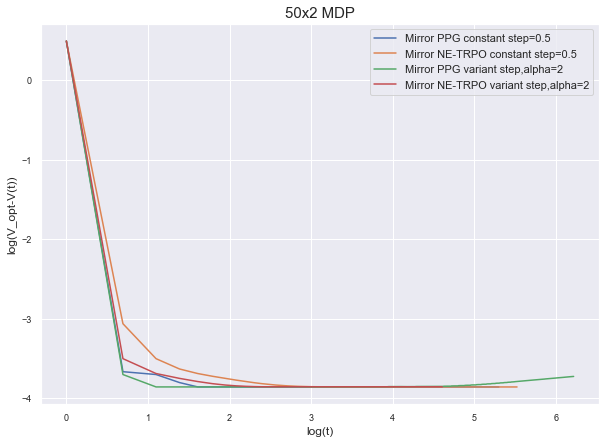

In [175]:
#current plot isnt showing lazy mirror
plot_log(history_lazy_md,history_ppg_cstep,history_ne_cstep,history_ppg_vstep,history_ne_vstep)

In [176]:
def plot_log(V_lazy_md,V_ppg_cstep,V_ne_cstep,V_ppg_vstep,V_ne_vstep):
    
    #x=np.array(range(0,iterations))
    x1=(np.array(range(1,len(V_lazy_md)+1)))
    y1=(np.array(V_lazy_md)[:])

    x2=(np.array(range(1,len(V_ppg_cstep)+1)))
    y2=(np.array(V_ppg_cstep)[:])
    
    x3=(np.array(range(1,len(V_ne_cstep)+1)))
    y3=(np.array(V_ne_cstep)[:])
    
    x4=(np.array(range(1,len(V_ppg_vstep)+1)))
    y4=(np.array(V_ppg_vstep)[:])
    
    x5=(np.array(range(1,len(V_ne_vstep)+1)))
    y5=(np.array(V_ne_vstep)[:])
    
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('iterations', fontsize=15)
    plt.ylabel('V(rho)', fontsize=15)
    plt.plot(x1,y1,label='Lazy mirror step=0.5') 
    plt.plot(x2,y2,label='Mirror PPG constant step=0.5')
    plt.plot(x3,y3,label='Mirror NE-TRPO constant step=0.5')
    plt.plot(x4,y4,label='Mirror PPG variant step,alpha=2')
    plt.plot(x5,y5,label='Mirror NE-TRPO variant step,alpha=2')
    plt.title('50x2 MDP',fontsize=15)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

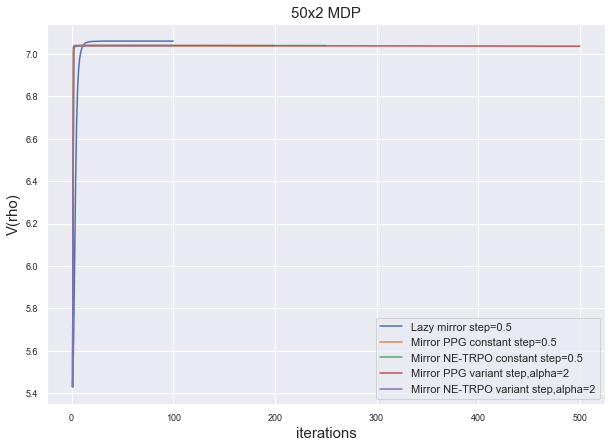

In [177]:
plot_log(V_lazy_md,V_ppg_cstep,V_ne_cstep,V_ppg_vstep,V_ne_vstep)

## Observation

#### We see that both mirror and lazy-mirror descent converge to the optimal solution with almost the same rate of convergence